# ML2025F: 2025-2 머신러닝 프로젝트
## 문제 정의
#### 연구 가설
인종과 부모 교육 수준이 학생의 학업 수준에 영향을 줄 것이다  
#### 머신러닝 모델
시각화: 피처별 학업 수준 플롯 작성  
머신러닝: 피처로부터 학업 수준을 예측하는 회귀모델 작성  

## 데이터 정의
#### 데이터 확보 방안
Kaggle 오픈 데이터 “Exploring Student Achievement”  
#### 데이터 명세 기술
파일 포맷: .csv  
데이터 사이즈: 컬럼 8개, 레코드 1000개  
컬럼 명세  
성별: 남, 여  
인종: A, B, C, D, E  
부모 교육 수준: 고교 중퇴, 고교 졸업, 대학 중퇴, 대학 수료, 대학 졸업(학사), 대학 졸업(석사)  
급식 유형: 표준 급식, 무료 급식  
시험 준비 상태: 완료, 완료하지 않음  
수학 점수  
읽기 점수  
쓰기 점수  

#### 데이터 로드

In [48]:
import numpy as             np
import pandas as            pd
import matplotlib.pyplot as plt
import seaborn as           sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import    LinearRegression

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [49]:
df=pd.read_csv("./data.csv")

# 컬럼 리네임
df=df.rename(
    columns={
        "gender":                     "GEN",
        "race/ethnicity":             "ETH",
        "parental level of education":"EDU",
        "lunch":                      "LUN",
        "test preparation course":    "TPC",
        "math score":                 "MAT",
        "reading score":              "REA",
        "writing score":              "WRI",
    }
)
df.head()

,GEN,ETH,EDU,LUN,TPC,MAT,REA,WRI
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


## 데이터 처리 과정
#### 누락 데이터 처리 과정

In [50]:
# 결측치 탐지
print(df.isnull().sum())

GEN    0
ETH    0
EDU    0
LUN    0
TPC    0
MAT    0
REA    0
WRI    0
dtype: int64


#### 이상치 처리 과정

In [51]:
# 점수 피처 범위 확인
print(((df[["MAT"]]>=0)&(df[["MAT"]]<=100)).sum())
print(((df[["REA"]]>=0)&(df[["REA"]]<=100)).sum())
print(((df[["WRI"]]>=0)&(df[["WRI"]]<=100)).sum())

MAT    1000
dtype: int64
REA    1000
dtype: int64
WRI    1000
dtype: int64


#### 데이터 시각화

In [52]:
# 피처별 과목 평균점수 시각화
def draw_avg(feat:str,df):    
    avg = df.groupby(feat)[["MAT","REA","WRI"]].mean().reset_index()
    avg = avg.melt(id_vars=feat,var_name="subject",value_name="avg score")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat,y="avg score",hue="subject",data=avg)
    plt.title("avg score: "+feat)
    plt.ylabel("avg score")
    plt.xlabel(feat+" group")
    plt.legend(title="subject")
    plt.ylim(0,100)
    plt.grid(axis="y")
    plt.show()

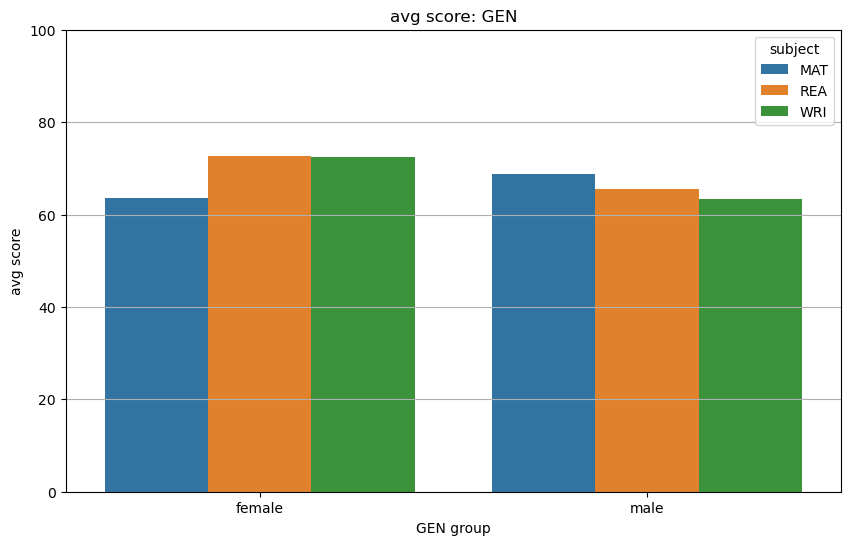

In [53]:
#GEN: 성별
draw_avg("GEN",df)

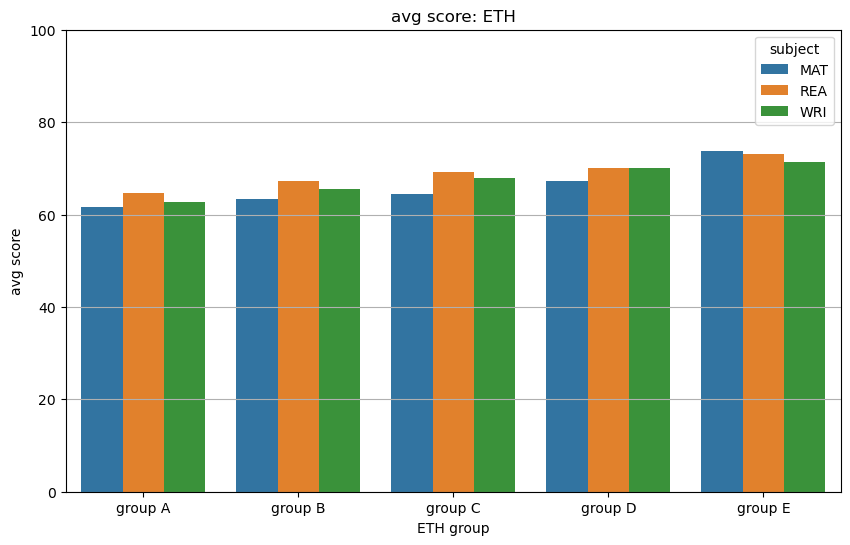

In [54]:
#ETH: 인종
draw_avg("ETH",df)

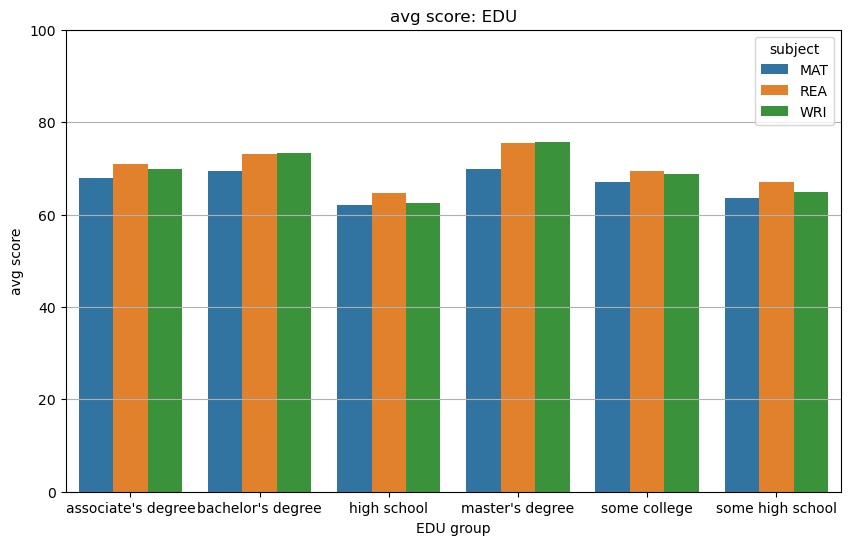

In [55]:
#EDU: 부모 교육 수준
draw_avg("EDU",df)

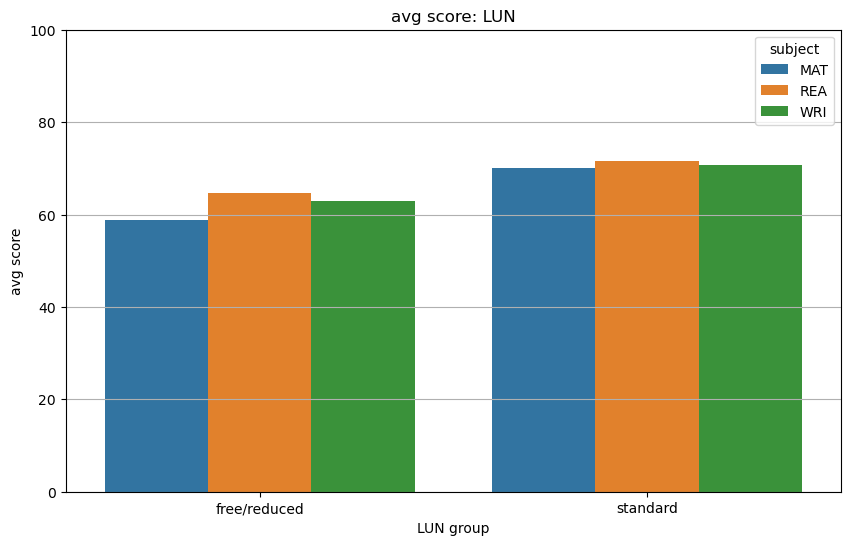

In [56]:
#LUN: 급식 유형
draw_avg("LUN",df)

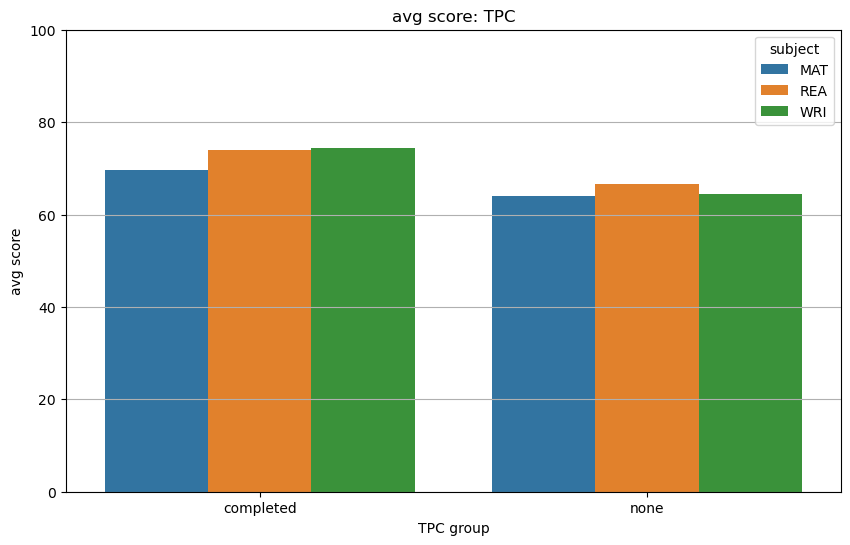

In [57]:
#TPC: 시험 준비 상태
draw_avg("TPC",df)

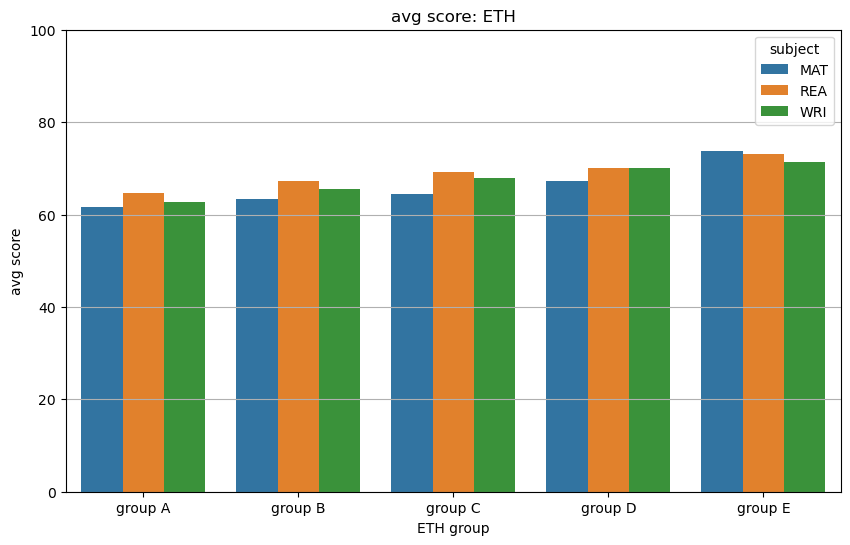

In [58]:
# ETH
draw_avg("ETH",df)

#### 레이블 인코딩

In [59]:
# 피처 레이블 도메인 확인
for i in df["GEN"].unique():print(i) # gender
for i in df["ETH"].unique():print(i) # race/ethnicity
for i in df["EDU"].unique():print(i) # parental level of education
for i in df["LUN"].unique():print(i) # lunch
for i in df["TPC"].unique():print(i) # test preparation course

female
male
group B
group C
group A
group D
group E
bachelor's degree
some college
master's degree
associate's degree
high school
some high school
standard
free/reduced
none
completed


In [60]:
# 원-핫 인코딩: 성별
df["GEN_M"]=(df["GEN"]=="male")
df["GEN_F"]=(df["GEN"]=="female")
df=df.drop(columns=["GEN"])

# 원-핫 인코딩: 인종
df["ETH_A"]=(df["ETH"]=="group A")
df["ETH_B"]=(df["ETH"]=="group B")
df["ETH_C"]=(df["ETH"]=="group C")
df["ETH_D"]=(df["ETH"]=="group D")
df["ETH_E"]=(df["ETH"]=="group E")
df=df.drop(columns=["ETH"])

df.head()

,EDU,LUN,TPC,MAT,REA,WRI,GEN_M,GEN_F,ETH_A,ETH_B,ETH_C,ETH_D,ETH_E
0,bachelor's degree,standard,none,72,72,74,False,True,False,True,False,False,False
1,some college,standard,completed,69,90,88,False,True,False,False,True,False,False
2,master's degree,standard,none,90,95,93,False,True,False,True,False,False,False
3,associate's degree,free/reduced,none,47,57,44,True,False,True,False,False,False,False
4,some college,standard,none,76,78,75,True,False,False,False,True,False,False


In [61]:
# 레이블 인코딩: 부모 교육 수준, 급식 유형, 시험 준비 상태
MAP_EDU={
    "some high school":  1,
    "high school":       2,
    "associate's degree":3,
    "some college":      4,
    "bachelor's degree": 5,
    "master's degree":   6,
}
MAP_LUN={
    "free/reduced":1,
    "standard":    2,
}
MAP_TPC={
    "none":     1,
    "completed":2,
}
df["EDU"]=df["EDU"].map(MAP_EDU)
df["LUN"]=df["LUN"].map(MAP_LUN)
df["TPC"]=df["TPC"].map(MAP_TPC)

In [62]:
# 컬럼 순서 조정

df=df.reindex(
    columns=[
        "GEN_M","GEN_F",
        "ETH_A","ETH_B","ETH_C","ETH_D","ETH_E",
        "EDU",
        "LUN",
        "TPC",
        "MAT",
        "REA",
        "WRI",
    ]
)
df.head()

,GEN_M,GEN_F,ETH_A,ETH_B,ETH_C,ETH_D,ETH_E,EDU,LUN,TPC,MAT,REA,WRI
0,False,True,False,True,False,False,False,5,2,1,72,72,74
1,False,True,False,False,True,False,False,4,2,2,69,90,88
2,False,True,False,True,False,False,False,6,2,1,90,95,93
3,True,False,True,False,False,False,False,3,1,1,47,57,44
4,True,False,False,False,True,False,False,4,2,1,76,78,75


## 모델 튜닝 과정

#### 모델 작성

In [63]:
data=train_test_split(
    df[["GEN_M","GEN_F","ETH_A","ETH_B","ETH_C","ETH_D","ETH_E","EDU","LUN","TPC"]],
    df[["MAT","REA","WRI"]],
    test_size=0.2,
    random_state=42,
)
X_train=data[0]
X_test =data[1]
Y_train=data[2]
Y_test =data[3]

model=LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

#### 성능 평가

In [64]:
Y_pred = model.predict(X_test)

for i, subject in enumerate(["MAT","REA","WRI"]):
    print("과목:",subject)
    print("mae :",np.round(mean_absolute_error(Y_test.iloc[:,i],Y_pred[:,i]),3))
    print("mse :",np.round(mean_squared_error(Y_test.iloc[:,i],Y_pred[:,i]), 3))
    print("rmse:",np.round(np.sqrt(mse),                                     3))
    print("r2  :",np.round(r2_score(Y_test.iloc[:, i], Y_pred[:, i]),        3))
    print()

과목: MAT
mae : 11.172
mse : 198.993
rmse: 13.21
r2  : 0.182

과목: REA
mae : 10.876
mse : 188.893
rmse: 13.21
r2  : 0.165

과목: WRI
mae : 10.077
mse : 174.513
rmse: 13.21
r2  : 0.276



## 결론
#### 결론
모델 설명력 낮음  
성별, 인종, 부모 교육 수준, 급식 유형, 시험 준비 상태와 학생 학업 수준 사이의 통계적 유의성 낮음  